<a href="https://colab.research.google.com/github/anmolkhurana490/Sign-Language-Translator/blob/main/model_training/video_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and Importing Necessary Libraries

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import os
import json

In [ ]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Data Importing from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

def extract_zip(dir_name):
  # Replace with the actual path to your zip file in Google Drive
  zip_file_path = f'/content/drive/MyDrive/Sign-Language-Translator/data/{dir_name}.zip'
  # Replace with the desired extraction location in Colab
  extract_path = f'/content/Sign-Language-Translator/'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

for dir_name in ['Videos_Sentence_Level']:
  extract_zip(dir_name)

Successfully unzipped /content/drive/MyDrive/Sign-Language-Translator/data/Videos_Sentence_Level.zip to /content/Sign-Language-Translator/


Mediapipe Landmarks Extraction

In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2
)

In [ ]:
def detect_landmarks(image):
    results = holistic.process(image)

    landmarks = {
        'left_hand': None,
        'right_hand': None,
        'pose': None,
        # 'face': None
    }

    if results.left_hand_landmarks:
        landmarks['left_hand'] = results.left_hand_landmarks

    if results.right_hand_landmarks:
        landmarks['right_hand'] = results.right_hand_landmarks

    if results.pose_landmarks:
        landmarks['pose'] = results.pose_landmarks

    # if results.face_landmarks:
    #     landmarks['face'] = results.face_landmarks

    return landmarks

In [ ]:
def process_frame(frame):
    frame = cv2.resize(frame, (640, 480))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    result = detect_landmarks(frame_rgb)

    if result['left_hand']:
      mp_drawing.draw_landmarks(frame, result['left_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['right_hand']:
      mp_drawing.draw_landmarks(frame, result['right_hand'], mp_holistic.HAND_CONNECTIONS)

    if result['pose']:
      mp_drawing.draw_landmarks(frame, result['pose'], mp_holistic.POSE_CONNECTIONS)

    # if result['face']:
    #   mp_drawing.draw_landmarks(frame, result['face'], mp_holistic.FACEMESH_TESSELATION)

    return frame

In [ ]:
# fps <= 25
def process_video(video_path, fps=25):
  cap = cv2.VideoCapture(video_path)

  if not cap.isOpened():
    print("Error opening video file:", video_path)
    return None

  frames = []

  total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  step = max(1, 25 // fps)

  for i in range(0, total, step):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()

    if ret:
      frame = process_frame(frame)
      frames.append(frame)

  cap.release()

  return np.array(frames)

In [ ]:
sentence_data_path = '/content/Sign-Language-Translator/Videos_Sentence_Level'

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
processed_frames = process_video(os.path.join(sentence_data_path, 'He_is_going_into_the_room/room.MP4'), fps=4)

# Calculate the number of rows and columns for the grid
num_frames = len(processed_frames)
cols = 5  # You can adjust the number of columns
rows = (num_frames + cols - 1) // cols

plt.figure(figsize=(20, rows * 4))  # Adjust figure size as needed

for i, frame in enumerate(processed_frames):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {i+1}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
processed_frames.shape

(19, 480, 640, 3)

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = process_frame(frame)

    cv2.imshow('Hand Landmarks', frame)
    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()

Data Preprocessing and Loading

In [ ]:
classes = os.listdir(sentence_data_path)
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 101


In [ ]:
# saving data classes into JSON
def save_all_classes(classes, json_path):
    json.dump(classes, open(json_path, 'w'), indent=4)
    print(f"Class names saved to {json_path}")

save_all_classes(classes, '/content/drive/MyDrive/Sign-Language-Translator/data/sentence_class_names.json')

Class names saved to /content/drive/MyDrive/Sign-Language-Translator/data/sentence_class_names.json


In [ ]:
class_to_label = {class_name: i for i, class_name in enumerate(classes)}
label_to_class = {i: class_name for i, class_name in enumerate(classes)}

In [ ]:
num_files = {}

for class_name in os.listdir(sentence_data_path):
  class_dir = os.path.join(sentence_data_path, class_name)
  class_files = len(os.listdir(class_dir))

  label = class_to_label[class_name]
  num_files[label] = class_files

  if class_files >= 50:
    print(class_name, class_files)

print(num_files)
print("Max files:", max(num_files.values()))

{0: 9, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 1, 12: 7, 13: 7, 14: 7, 15: 7, 16: 8, 17: 7, 18: 7, 19: 7, 20: 6, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 8, 27: 7, 28: 7, 29: 6, 30: 7, 31: 8, 32: 7, 33: 7, 34: 7, 35: 7, 36: 7, 37: 7, 38: 7, 39: 7, 40: 7, 41: 7, 42: 7, 43: 7, 44: 7, 45: 6, 46: 7, 47: 3, 48: 7, 49: 7, 50: 7, 51: 7, 52: 7, 53: 7, 54: 6, 55: 7, 56: 7, 57: 6, 58: 7, 59: 7, 60: 6, 61: 6, 62: 7, 63: 7, 64: 7, 65: 6, 66: 7, 67: 7, 68: 8, 69: 7, 70: 6, 71: 7, 72: 6, 73: 6, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7, 79: 7, 80: 7, 81: 7, 82: 7, 83: 7, 84: 7, 85: 8, 86: 7, 87: 7, 88: 1, 89: 6, 90: 7, 91: 8, 92: 7, 93: 7, 94: 7, 95: 7, 96: 7, 97: 7, 98: 7, 99: 7, 100: 7}
Max files: 9


In [ ]:
max_frames = 0
max_fps = 0

for class_name in os.listdir(sentence_data_path):
  class_dir = os.path.join(sentence_data_path, class_name)

  for video_name in os.listdir(class_dir):
    video_path = os.path.join(class_dir, video_name)

    cap = cv2.VideoCapture(video_path)

    if cap.get(cv2.CAP_PROP_FRAME_COUNT) > 250:
      print("outlier video path:", video_path, "frames:", cap.get(cv2.CAP_PROP_FRAME_COUNT))
    else:
      max_frames = max(max_frames, cap.get(cv2.CAP_PROP_FRAME_COUNT))
      max_fps = max(max_fps, cap.get(cv2.CAP_PROP_FPS))

    cap.release()

print("max frames:", max_frames, "fps:", max_fps)
# total = 25 - 192, fps = 25
# duration = 1 - 180 sec

outlier video path: /content/Sign-Language-Translator/Videos_Sentence_Level/i_do_not_like_it/i_do_not_like_it_(2).mp4 frames: 4500.0
max frames: 192.0 fps: 25.0


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, v2
from torchcodec.decoders import VideoDecoder

In [ ]:
def load_video(video_path):
  try:
    decoder = VideoDecoder(video_path)
  except Exception as e:
    print(f"Error loading video: {e}")
    return None

  # Outlier Video found (duration > 10s)
  if decoder.metadata.duration_seconds > 10:
    # get max 8 sec video
    decoder = decoder[:200]

  return decoder # shape = N, C, H, W

In [ ]:
def normalize_landmarks(landmarks):
  left_shoulder, right_shoulder = landmarks[2][11], landmarks[2][12]

  # shoulder center
  root = (left_shoulder + right_shoulder) / 2.0

  scale = torch.linalg.norm(left_shoulder - right_shoulder).to(dtype=torch.float64)

  # avoid division by 0
  if scale < 1e-6:
    scale = 1.0

  landmarks[0] = (landmarks[0] - root) / scale
  landmarks[1] = (landmarks[1] - root) / scale
  landmarks[2] = (landmarks[2] - root) / scale
  # landmarks[3] = (landmarks[3] - root) / scale

  # new_lm = old_lm + (to_point - from_point)
  landmarks[0] += (landmarks[2][16] - landmarks[0][0])
  landmarks[1] += (landmarks[2][15] - landmarks[1][0])
  # landmarks[3] += (landmarks[2][0] - landmarks[3][1])

  return landmarks

In [ ]:
def extract_landmarks(image):
  if image.shape[0] == 3:
    image = image.permute((1, 2, 0))

  image = np.array(image)

  original_landmarks = []

  num_landmarks = {
      'left_hand': 21,
      'right_hand': 21,
      'pose': 25,
      # 'pose': 33,
      'face': 0
      # 'face': 468
  }

  result = detect_landmarks(image)

  for part_type, landmarks in result.items():
    if landmarks:
      landmark_list = torch.tensor([(lm.x,lm.y,lm.z,lm.visibility) for lm in landmarks.landmark], dtype=torch.float64)
      landmark_list = landmark_list[:num_landmarks[part_type]]
    else:
      landmark_list = torch.tensor([(0,0,0,0)] * num_landmarks[part_type], dtype=torch.float64)

    original_landmarks.append(landmark_list)

  normalized_landmarks = normalize_landmarks(original_landmarks)
  original_landmarks = torch.concat(normalized_landmarks, dim=0)

  return original_landmarks.to(dtype=torch.float64)

In [ ]:
def load_saved_data(data_path, train=False):
  if not os.path.exists(data_path):
    return []

  data_type = 'train' if train else 'test'
  features, labels = torch.load(data_path)[data_type]
  return list(zip(features, labels))

In [ ]:
data_path = '/content/drive/MyDrive/Sign-Language-Translator/data/preprocessed_video_sentence_data.pth'
# data = load_saved_data(data_path)
# data[0][0].shape, data[0][1]

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_files_split(data_dir, test_ratio=0.2):
  video_paths = []
  labels = []

  for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)

    for video_name in os.listdir(class_dir):
      video_path = os.path.join(class_dir, video_name)
      video_paths.append(video_path)
      labels.append(class_to_label[class_name])

      if len(os.listdir(class_dir)) == 1:
        video_paths.append(video_path)
        labels.append(class_to_label[class_name])

  test_size = int(len(video_paths) * test_ratio)

  train_videos, test_videos, train_labels, test_labels = train_test_split(video_paths, labels, test_size=test_size, stratify=labels)

  train_set = list(zip(train_videos, train_labels))
  test_set = list(zip(test_videos, test_labels))

  return train_set, test_set

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, data_list,
                 frame_transform=None, temporal_transform=None, landmark_transform=None,
                 max_augments=1, saved_data_path='', train=False):
        self.video_paths = []
        self.labels = []

        self.cache = {}
        self.cache = dict(enumerate(load_saved_data(saved_data_path, train)))

        self.frame_transform = frame_transform
        self.temporal_transform = temporal_transform
        self.landmark_transform = landmark_transform

        for file in data_list:
          num_augments = max(1, max_augments // num_files[file[1]])

          for _ in range(num_augments):
            self.video_paths.append(file[0])
            self.labels.append(file[1])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path, label = self.video_paths[idx], self.labels[idx]

        if idx in self.cache:
          cached_data = self.cache[idx]
          if cached_data[0] is not None:
            return cached_data[0], class_to_label[cached_data[1]]

        video_frames = load_video(video_path)

        if video_frames is None:
          self.cache[idx] = None
          return None, label

        # Temporal Transform
        if self.temporal_transform:
          video_frames = self.temporal_transform(video_frames)
        else:
          video_frames = video_frames[::5]

        # Frame Transformation
        if self.frame_transform:
          video_frames = self.frame_transform(video_frames)

        # extracting videl landmarks
        # shape = N, 33, 3
        video_landmarks = torch.stack([extract_landmarks(frame) for frame in video_frames])

        # video landmarks transformations
        if self.landmark_transform:
          video_landmarks = self.landmark_transform(video_landmarks)

        # video = video.to(torch.float64) / 255.0
        self.cache[idx] = video_landmarks, label_to_class[label]

        return video_landmarks, label

def video_collate_fn(batch):
  batch = list(filter(lambda x: x[1] is not None, batch))

  videos, labels = zip(*batch)
  max_size = max(video.shape[0] for video in videos)

  padded_videos = []
  for video in videos:
    pad_size = max_size - video.shape[0]
    pad_tensor = torch.zeros((pad_size, *video.shape[1:]))
    padded_videos.append(torch.cat([pad_tensor, video], dim=0))

  return torch.stack(padded_videos), torch.tensor(labels)

In [ ]:
frame_transform = v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(p=0.5),

    # ✅ Spatial variations
    v2.RandomResizedCrop(size=(256,256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    # v2.RandomPerspective(distortion_scale=0.1, p=0.5),
    v2.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),

    # ✅ Photometric variations
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),

    # ✅ Occlusion & robustness
    v2.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
])

In [ ]:
import math
import random

In [ ]:
def temporal_transform(frames):
  # Time warping
  step = random.choice(range(3, 8))
  frames = frames[::step]

  # Time Jiterring

  # Frame Dropping
  drop_prob = 0.1
  keep = [frame for frame in frames if random.random() > drop_prob]
  if len(keep) > 3:
    frames = torch.stack(keep)

  # Frame Mask
  mask_prob = 0.1
  idx = random.choices(range(frames.shape[0]), k=int(frames.shape[0]*mask_prob))
  frames[idx] = torch.zeros_like(frames[idx])

  return frames

In [ ]:
def random_rotation_matrix():
    """Generate a random 3D rotation matrix (Rx * Ry * Rz)."""

    # random angles (radians)
    ax = np.radians(np.random.uniform(-15, 15))  # rotation about x-axis
    ay = np.radians(np.random.uniform(-15, 15))  # rotation about y-axis
    az = np.radians(np.random.uniform(-15, 15))  # rotation about z-axis

    # Rotation matrices
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(ax), -np.sin(ax)],
                   [0, np.sin(ax),  np.cos(ax)]])

    Ry = np.array([[ np.cos(ay), 0, np.sin(ay)],
                   [0, 1, 0],
                   [-np.sin(ay), 0, np.cos(ay)]])

    Rz = np.array([[np.cos(az), -np.sin(az), 0],
                   [np.sin(az),  np.cos(az), 0],
                   [0, 0, 1]])

    # Combined rotation
    return Rz @ Ry @ Rx

def landmark_transform(landmarks, prob=0.5):
    """
    landmarks: numpy array shape (num_joints, 4) -> [x, y, z, visibility]
    """
    lm = landmarks

    # if np.random.rand() < prob:
    #     # 1. Scaling (simulates zoom in/out)
    #     scale = np.random.uniform(0.9, 1.1)
    #     lm[:, :, :3] *= scale

    # if np.random.rand() < prob:
    #     # 2. Translation (shifting body position)
    #     tx, ty, tz = np.random.uniform(-0.05, 0.05, size=3)  # shift by 5%
    #     lm[:, :, 0] += tx
    #     lm[:, :, 1] += ty
    #     lm[:, :, 2] += tz

    if np.random.rand() < prob:
        # 3. 3D rotation
        rot = random_rotation_matrix()
        lm[:, :, :3] = lm[:, :, :3] @ rot.T

    # if np.random.rand() < prob:
    #     # 4. Gaussian noise (sensor jitter)
    #     lm[:, :, :3] += np.random.normal(0, 1e-6, lm[:, :, :3].shape)

    return lm

In [ ]:
train_files, test_files = train_test_files_split(sentence_data_path, test_ratio=0.2)

train_dataset = HandGestureDataset(
    train_files,
    frame_transform=frame_transform,
    temporal_transform=temporal_transform,
    landmark_transform=landmark_transform,
    max_augments=50,
    # saved_data_path=data_path,
    # train=True
)

test_dataset = HandGestureDataset(
    test_files,
    # saved_data_path=data_path
)

In [ ]:
len(train_dataset), len(test_dataset)

(3978, 137)

In [ ]:
train_dataset[0][0].shape, train_dataset[0][1]

(torch.Size([30, 67, 4]), 44)

In [ ]:
# Create DataLoaders for the training and testing datasets
# Set num_workers to 0 to avoid CUDA re-initialization issues with multiprocessing
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, collate_fn=video_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=video_collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 3978
Testing dataset size: 137


In [ ]:
for i, (x_batch, y_batch) in enumerate(train_dataloader):
  print(f"{i}.", "Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

0. Features data shape: torch.Size([20, 34, 67, 4]) Label: torch.Size([20])
1. Features data shape: torch.Size([20, 32, 67, 4]) Label: torch.Size([20])
2. Features data shape: torch.Size([20, 44, 67, 4]) Label: torch.Size([20])
3. Features data shape: torch.Size([20, 37, 67, 4]) Label: torch.Size([20])
4. Features data shape: torch.Size([20, 43, 67, 4]) Label: torch.Size([20])
5. Features data shape: torch.Size([20, 37, 67, 4]) Label: torch.Size([20])
6. Features data shape: torch.Size([20, 37, 67, 4]) Label: torch.Size([20])
7. Features data shape: torch.Size([20, 48, 67, 4]) Label: torch.Size([20])
8. Features data shape: torch.Size([20, 34, 67, 4]) Label: torch.Size([20])
9. Features data shape: torch.Size([20, 41, 67, 4]) Label: torch.Size([20])
10. Features data shape: torch.Size([20, 34, 67, 4]) Label: torch.Size([20])
11. Features data shape: torch.Size([20, 36, 67, 4]) Label: torch.Size([20])
12. Features data shape: torch.Size([20, 43, 67, 4]) Label: torch.Size([20])
13. Featu

In [ ]:
for i, (x_batch, y_batch) in enumerate(test_dataloader):
  print(f"{i}.", "Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Saving Preprocessed Dataset

In [ ]:
def collect_data(dataset):
  # collected all data to store
  all_features = []
  all_labels = []

  for x, y in dataset:
    all_features.append(x)
    all_labels.append(label_to_class[y])

  all_data = (all_features, all_labels)
  return all_data

In [ ]:
# Save the cached data with .pth extension
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/data'
data_path = os.path.join(save_directory, 'preprocessed_video_sentence_data.pth')

combined_data = {
  'train': collect_data(train_dataset),
  'test': collect_data(test_dataset)
}

torch.save(combined_data, data_path)

Data Visualization

In [ ]:
skeleton_edges = [
    # Left Hand
    (0, 1), (1, 2), (2, 3), (3, 4), # thumb
    (0, 5), (5, 6), (6, 7), (7, 8), # index
    (0, 9), (9, 10), (10, 11), (11, 12), # middle
    (0, 13), (13, 14), (14, 15), (15, 16), # ring
    (0, 17), (17, 18), (18, 19), (19, 20), # pinky

    # Right Hand
    (21, 22), (22, 23), (23, 24), (24, 25), # thumb
    (21, 26), (26, 27), (27, 28), (28, 29), # index
    (21, 30), (30, 31), (31, 32), (32, 33), # middle
    (21, 34), (34, 35), (35, 36), (36, 37), # ring
    (21, 38), (38, 39), (39, 40), (40, 41), # pinky

    # Pose
    (53, 55), (55, 57), # Left Arm
    (54, 56), (56, 58), # Right Arm
    (53, 54),             # Shoulders
    (53, 65), (54, 66),   # Torso
    (65, 66),             # Hips
    (42, 53), (42, 54),   # Nose to Shoulders
    # (66, 68), (68, 70),   # Hips to Left Leg
    # (65, 67), (67, 69),   # Hips to Right Leg

    # (0, 57), (21, 58) # Hands wrist to Pose wrist
]

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_frame_landmarks(frame_data_list, skeleton_edges):
  """
  Visualizes the landmarks for a list of frames in 3D subplots.

  Args:
    frame_data_list (list): A list of torch.Tensor, where each tensor is of shape
                            [num_landmarks, 3] containing the x, y, z coordinates
                            of landmarks for a single frame.
    skeleton_edges (list): A list of tuples representing connections between landmarks.
  """
  num_frames = len(frame_data_list)
  cols = 5 # Number of columns in the subplot grid
  rows = (num_frames + cols - 1) // cols # Calculate number of rows

  fig = plt.figure(figsize=(cols * 3, rows * 3))

  for i, frame_data in enumerate(frame_data_list):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')

    # Plot the landmarks
    ax.scatter(frame_data[:21, 0], frame_data[:21, 1], frame_data[:21, 2], marker='o')
    ax.scatter(frame_data[21:42, 0], frame_data[21:42, 1], frame_data[21:42, 2], marker='_')
    ax.scatter(frame_data[42, 0], frame_data[42, 1], frame_data[42, 2], marker='*')
    ax.scatter(frame_data[43:75, 0], frame_data[43:75, 1], frame_data[43:75, 2], marker='.')
    ax.scatter(frame_data[75:, 0], frame_data[75:, 1], frame_data[75:, 2], marker='x')

    # Plot the connections (skeleton)
    for k, l in skeleton_edges:
      x = [frame_data[k, 0], frame_data[l, 0]]
      y = [frame_data[k, 1], frame_data[l, 1]]
      z = [frame_data[k, 2], frame_data[l, 2]]
      ax.plot(x, y, z, 'blue')

    ax.set_title(f'Frame {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.gca().invert_zaxis()

  plt.tight_layout()
  plt.show()

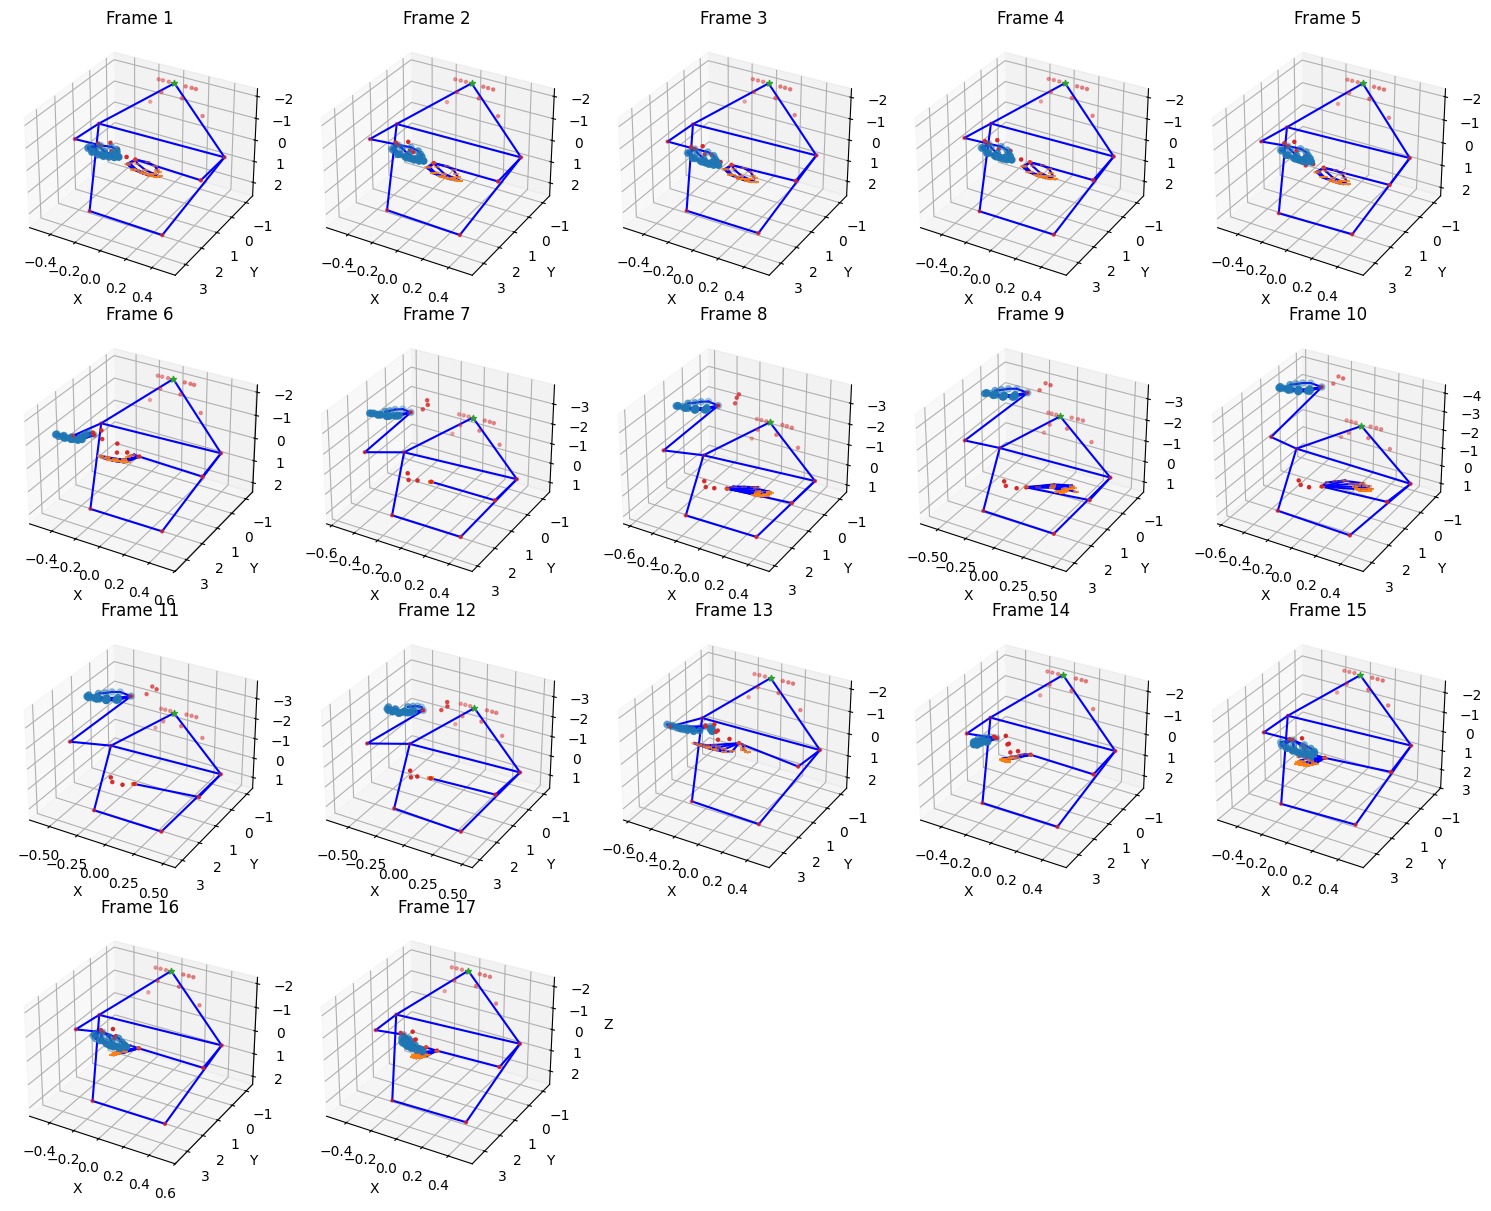

/content/Sign-Language-Translator/Videos_Sentence_Level/i_am_afraid_of_that/afraid_(3).MP4


In [ ]:
# Example usage: Visualize the first frame of the first video in the dataset
# Assuming dataset[0][0] is the first video and has shape [num_frames, num_landmarks, 3]
frames = test_dataset[100][1] # Get the first frame
visualize_frame_landmarks(frames, skeleton_edges)
print(test_dataset[100][0])

In [ ]:
# right hand wrist
frames[0][21], frames[0][57]

(tensor([ 0.6765,  2.4418, -0.5462, -3.7321], dtype=torch.float64),
 tensor([ 0.6765,  2.4418, -0.5462, -3.7321], dtype=torch.float64))